In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import sys
sys.version

'3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]'

# $\bullet$ Check every path X$\to$Z 
    (if active path, break)
###      Check every triple for each path
## $\bullet$ V-Structure: If the middle node and its descendants are unobserved $\Rightarrow$ inactive triple $\Rightarrow$ $\color{red}{\textbf{inactive path}}$
## $\bullet$ Common Cause: If the middle node is unobserved $\Rightarrow$ $\color{green}{\textbf{active triple}}$, continue... If observed $\Rightarrow$ inactive triple $\Rightarrow$  $\color{red}{\textbf{inactive path}}$.
## $\bullet$  Causal Chain: If the middle node is unobserved $\Rightarrow$ $\color{green}{\textbf{active path}}$, continue... If observed $\Rightarrow$ inactive triple $\Rightarrow$  $\color{red}{\textbf{inactive path}}$. 

### $\to$ Once we identify a $\color{orange}{\textbf{path}}$ where all the triples on the path are active, we can immediately halt and confidently establish a $\color{blue}{\textbf{conditional dependency}}$.

### $\to$ On the other hand, for $\color{purple}{\textbf{conditional 𝐢𝐧𝐝𝐞𝐩𝐞𝐧𝐝𝐞𝐧𝐜𝐞}}$ ALL the paths must be $\color{red}{\textbf{inactive}}$.

In [37]:
def get_subsets(L: list):
    subsets = []
    
    for k in range(len(L) +1):
        for subset in itertools.combinations(L, k):
            subsets.append(list(subset))
    return subsets



class PGM_Ind:
    def __init__(self, graph: list): #list of tuples
        self.graph = graph
        self.G = nx.DiGraph(graph)
        self.generate_triples = lambda L: [(L[i], L[i+1], L[i+2]) for i in range(len(L) - 2)]
    
    def __str__(self):
        return f'{self.graph}'
    
    def __repr__(self):
        # Draw the graph
        highlight_nodes = []
            
        # set the position according to column (x-coord)
        nodes = list(self.G.nodes())
        random.shuffle(nodes)
        left_nodes = nodes[:len(nodes)//3+1]
        middle_nodes = nodes[len(nodes)//3+1:2*len(nodes)//3+1]
        right_nodes = nodes[2*len(nodes)//3 +1:]

        pos = {n: (0, i) for i, n in enumerate(left_nodes)}
        pos.update({n: (1, i + 0.5) for i, n in enumerate(middle_nodes)})
        pos.update({n: (2, i + 0.5) for i, n in enumerate(right_nodes)})

        # set up the plot parameters
        options = {
            'node_color': 'lightblue',
            'node_size': 950,
            'edge_color': 'black',
            'width': 0.75,
            'arrowstyle': '-|>',
            'arrowsize': 10,
            'font_color': 'black',
            'font_size': 14,
            'font_weight': 'bold',
            'pos': pos,
            }
        
        fig, ax = plt.subplots(figsize=(7.3, 4.5))  # set the plot size
        ax.set_title(f'Bayesian Network')  # set the plot title

        # draw the nodes and edges
        nx.draw_networkx(self.G, **options, ax=ax)
     
        # set the axis off
        ax.axis('off')
        # show the plot
        plt.show()
            
        return '';
     
    
    def triple_type(self, triple: tuple):
        x, y, z = triple

        ### x -> y <- z (but acyclic)
        if self.G.has_edge(x, y) and self.G.has_edge(z, y) and not (self.G.has_edge(x, z) or self.G.has_edge(z, x)):
            return 'V_structure'

        ### x -> y -> z (but acyclic)
        elif self.G.has_edge(x, y) and self.G.has_edge(y, z) and not (self.G.has_edge(x, z) or self.G.has_edge(z, x)):
            return 'causal_chain'

        ### symmetric case: z -> y -> x
        elif self.G.has_edge(z, y) and self.G.has_edge(y, x) and not (self.G.has_edge(x, z) or self.G.has_edge(z, x)):
            return 'causal_chain'

        else:
            return 'common_cause'
    
    def path_type(self, path: list, condition_set: list = []):
        triples = self.generate_triples(path)
        active_triples = []

        triples_type = list(map(self.triple_type, triples))

        for i, triple in enumerate(triples):
            left_node, mid_node, right_node = triple

            #If mid_node and its descedants are not observed, we have an inactive triple, hence an inactive path
            if triples_type[i] == 'V_structure':
                if (mid_node not in condition_set) and not any(elem in condition_set for elem in nx.descendants(self.G, mid_node)):
                    return 'inactive' 
                else:
                    return 'active'

            #For causal-chain or common-cause
            else: 
                if mid_node in condition_set:
                    return 'inactive'
                else:
                    return 'active'


    def Ind(self, X, Y, condition_set: list = [], get_info: str = False):
        
        undir_G = self.G.to_undirected() #note: we wish to check all the undirected paths
        paths = nx.all_simple_paths(undir_G, X, Y)
        all_paths = []

        type_of_each_path = []

        for path in paths:
            all_paths.append(path)

        for i, path in enumerate(all_paths):
            type_of_each_path.append(self.path_type(path, condition_set))

        binary_path_class = list(map(lambda x: 1 if x=='inactive' else 0,
                                     type_of_each_path))

        if get_info: print(f' Paths: {all_paths}\n', f'Type of paths: {type_of_each_path}\n')

        ###If all paths are inactive, then we guarantee 𝐜𝐨𝐧𝐝𝐢𝐭𝐢𝐨𝐧𝐚𝐥 𝐢𝐧𝐝𝐞𝐩𝐞𝐧𝐝𝐞𝐧𝐜𝐞
        if all(binary_path_class):
            return True

        #Otherwise, 𝐜𝐨𝐧𝐝𝐢𝐭𝐢𝐨𝐧𝐚𝐥 𝐢𝐧𝐝𝐞𝐩𝐞𝐧𝐝𝐞𝐧𝐜𝐞 is not guaranteed
        return False
    
    
    def all_comb(self):
        self.pairs = list(itertools.combinations(list(self.G.nodes), 2))
        self.I = []  ### save all the conditional independencies.
        self.D = []  ### save all the dep.
        
        for i, pair in enumerate(self.pairs):
            for condition_set in get_subsets(list(self.G.nodes)):
                if pair[0] not in condition_set and pair[1] not in condition_set:
                    cset = '∅' if condition_set==[] else set(condition_set)
                    IND = self.Ind(pair[0], pair[1], condition_set=condition_set)
                    print(f'{pair[0]} ⫫ {pair[1]} | {cset} : {IND}')
                    
                    #save the dep/ind
                    if IND:
                        self.I.append(f'{pair[0]} ⫫ {pair[1]} | {cset}')
                    else:
                        self.D.append(f'{pair[0]} ⫫ {pair[1]} | {cset}')
    
    def markov_blanket(self, X, info=False, plot:bool = False):
        childerns = list(self.G.successors(X))
        parents = list(self.G.predecessors(X))

        parents_of_childers = []
        for child in childerns:
            parents_of_childers.extend(list(self.G.predecessors(child)))

        # Remove duplicates from the list of parents
        parents_of_childers = list(set(parents_of_childers))

        Markov_Blanket = childerns + parents + parents_of_childers
        
        try:
            Markov_Blanket.remove(X) # Remove the trivial node
        except:
            pass

        if info:
            print(f'childerns of {X}: {childerns}\nparents of {X}: {parents}\nchildern\'s parents: {parents_of_childers}')
        
        
        if plot:      
            highlight_nodes = Markov_Blanket
            colors = ['orange' if node_name in highlight_nodes else 'lightblue' for node_name in list(self.G.nodes)]
            colors[list(self.G.nodes).index(X)] = (0.21,0.74,0.39)
            
            # set the position according to column (x-coord)
            nodes = list(self.G.nodes())
            random.shuffle(nodes)
            left_nodes = nodes[:len(nodes)//3+1]
            middle_nodes = nodes[len(nodes)//3+1:2*len(nodes)//3+1]
            right_nodes = nodes[2*len(nodes)//3 +1:]

            pos = {n: (0, i) for i, n in enumerate(left_nodes)}
            pos.update({n: (1, i + 0.5) for i, n in enumerate(middle_nodes)})
            pos.update({n: (2, i + 0.5) for i, n in enumerate(right_nodes)})

            # set up the plot parameters
            options = {
                'node_color': colors,
                'node_size': 950,
                'edge_color': 'black',
                'width': 0.75,
                'arrowstyle': '-|>',
                'arrowsize': 10,
                'font_color': 'black',
                'font_size': 14,
                'font_weight': 'bold',
                'pos': pos,
            }

            # create the plot
            fig, ax = plt.subplots(figsize=(7.3, 4.5))  # set the plot size
            ax.set_title(f'Markov Blanket of {X}')  # set the plot title

            # draw the nodes and edges
            nx.draw_networkx(self.G, **options, ax=ax)
            
            blanket_legend = ax.scatter([], [], s=18, color='orange', label='$\mathbf{Markov}$ $\mathbf{Blanket}$')
            target_legend = ax.scatter([], [], s=18, color=(0.21,0.74,0.39), label='$\mathbf{Target}$')

            # add the legends to the plot
            plt.legend(handles=[blanket_legend, target_legend], loc='upper right', fontsize='small')

            # set the axis off
            ax.axis('off')
            # show the plot
            plt.show()
            
            return;
        
        return Markov_Blanket
    
    




In [18]:
graph = [('U', 'W'), ('V', 'W'), ('W', 'Y'), ('X', 'Y'), 
                ('T', 'Z'), ('V', 'X'), ('V', 'T')] 

PGM1 = PGM_Ind(graph)

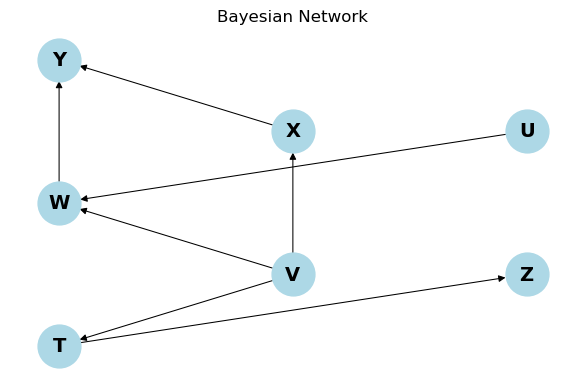

In [19]:
PGM1

In [7]:
PGM1.Ind('U', 'V', condition_set=['Z', 'T', 'Y', 'W'])

False

In [8]:
PGM1.Ind('X', 'T', condition_set=['Z', 'V'])

True

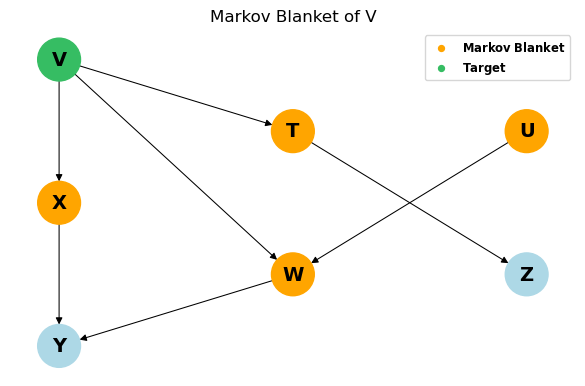

In [11]:
PGM1.markov_blanket('V', plot=True)

In [40]:
#PGM1.all_comb()

In [41]:
PGM1.I #Ind. set

["W ⫫ X | {'V'}",
 "W ⫫ X | {'V', 'U'}",
 "W ⫫ X | {'T', 'V'}",
 "W ⫫ X | {'Z', 'V'}",
 "W ⫫ X | {'T', 'V', 'U'}",
 "W ⫫ X | {'Z', 'V', 'U'}",
 "W ⫫ X | {'T', 'Z', 'V'}",
 "W ⫫ X | {'T', 'Z', 'V', 'U'}",
 "W ⫫ T | {'V'}",
 "W ⫫ T | {'V', 'U'}",
 "W ⫫ T | {'X', 'V'}",
 "W ⫫ T | {'Z', 'V'}",
 "W ⫫ T | {'X', 'V', 'U'}",
 "W ⫫ T | {'Z', 'V', 'U'}",
 "W ⫫ T | {'Z', 'X', 'V'}",
 "W ⫫ T | {'Z', 'X', 'V', 'U'}",
 "W ⫫ Z | {'V'}",
 "W ⫫ Z | {'V', 'U'}",
 "W ⫫ Z | {'X', 'V'}",
 "W ⫫ Z | {'T', 'V'}",
 "W ⫫ Z | {'X', 'V', 'U'}",
 "W ⫫ Z | {'T', 'V', 'U'}",
 "W ⫫ Z | {'T', 'X', 'V'}",
 "W ⫫ Z | {'T', 'X', 'V', 'U'}",
 "V ⫫ Y | {'W', 'X'}",
 "V ⫫ Y | {'W', 'X', 'U'}",
 "V ⫫ Y | {'T', 'W', 'X'}",
 "V ⫫ Y | {'Z', 'W', 'X'}",
 "V ⫫ Y | {'T', 'W', 'X', 'U'}",
 "V ⫫ Y | {'Z', 'W', 'X', 'U'}",
 "V ⫫ Y | {'T', 'Z', 'W', 'X'}",
 "V ⫫ Y | {'Z', 'W', 'T', 'U', 'X'}",
 "V ⫫ Z | {'T'}",
 "V ⫫ Z | {'T', 'U'}",
 "V ⫫ Z | {'T', 'W'}",
 "V ⫫ Z | {'Y', 'T'}",
 "V ⫫ Z | {'T', 'X'}",
 "V ⫫ Z | {'T', 'W', 'U'}",
 "V ⫫ 

In [44]:
PGM1.D[:20] #Dep. set

['U ⫫ W | ∅',
 "U ⫫ W | {'V'}",
 "U ⫫ W | {'Y'}",
 "U ⫫ W | {'X'}",
 "U ⫫ W | {'T'}",
 "U ⫫ W | {'Z'}",
 "U ⫫ W | {'Y', 'V'}",
 "U ⫫ W | {'X', 'V'}",
 "U ⫫ W | {'T', 'V'}",
 "U ⫫ W | {'Z', 'V'}",
 "U ⫫ W | {'Y', 'X'}",
 "U ⫫ W | {'Y', 'T'}",
 "U ⫫ W | {'Y', 'Z'}",
 "U ⫫ W | {'T', 'X'}",
 "U ⫫ W | {'Z', 'X'}",
 "U ⫫ W | {'T', 'Z'}",
 "U ⫫ W | {'Y', 'X', 'V'}",
 "U ⫫ W | {'Y', 'T', 'V'}",
 "U ⫫ W | {'Y', 'Z', 'V'}",
 "U ⫫ W | {'T', 'X', 'V'}"]

In [20]:
graph2 = [('X1', 'X2'), ('X1', 'X3'), ('X2', 'X4'), ('X2', 'X5'),
         ('X3', 'X6'), ('X3', 'X7'), ('X4', 'X5'), ('X4', 'X6'),
         ('X5', 'X7'), ('X6', 'X7'), ('X8', 'X9'), ('X8', 'X10'),
         ('X9', 'X11'), ('X10', 'X11'), ('X11', 'X7')]


PGM2 = PGM_Ind(graph2)

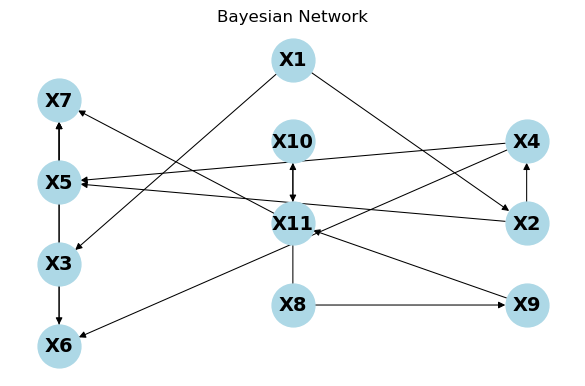

In [21]:
PGM2

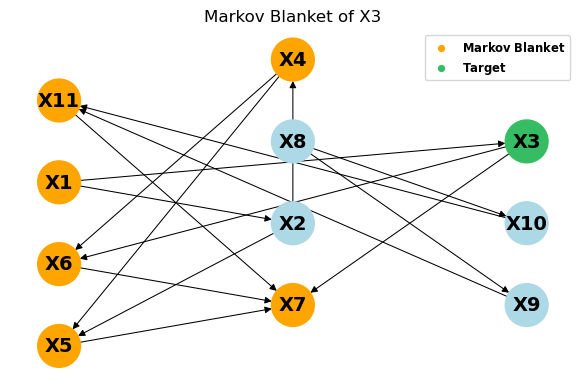

In [25]:
PGM2.markov_blanket('X3', plot=True)

In [ ]:
#PGM2.all_comb()

In [28]:
print(f'# of conditional independencies: {len(PGM2.I)}\n')
PGM2.I[:10]

# of conditional independencies: 3008



["X1 ⫫ X4 | {'X3', 'X2'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X5'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X6'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X7'}",
 "X1 ⫫ X4 | {'X8', 'X3', 'X2'}",
 "X1 ⫫ X4 | {'X9', 'X3', 'X2'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X10'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X11'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X5', 'X6'}",
 "X1 ⫫ X4 | {'X3', 'X2', 'X7', 'X5'}"]

In [29]:
print(f'# of conditional dependencies: {len(PGM2.D)}\n')
PGM2.D[:10]

# of conditional dependencies: 25152



['X1 ⫫ X2 | ∅',
 "X1 ⫫ X2 | {'X3'}",
 "X1 ⫫ X2 | {'X4'}",
 "X1 ⫫ X2 | {'X5'}",
 "X1 ⫫ X2 | {'X6'}",
 "X1 ⫫ X2 | {'X7'}",
 "X1 ⫫ X2 | {'X8'}",
 "X1 ⫫ X2 | {'X9'}",
 "X1 ⫫ X2 | {'X10'}",
 "X1 ⫫ X2 | {'X11'}"]

In [33]:
for var in PGM2.G.nodes:
    print(f'Markov Blanket of {var}: {PGM2.markov_blanket(var)}')

Markov Blanket of X1: ['X2', 'X3']
Markov Blanket of X2: ['X4', 'X5', 'X1', 'X4']
Markov Blanket of X3: ['X6', 'X7', 'X1', 'X6', 'X5', 'X4', 'X11']
Markov Blanket of X4: ['X5', 'X6', 'X2', 'X3', 'X2']
Markov Blanket of X5: ['X7', 'X2', 'X4', 'X3', 'X11', 'X6']
Markov Blanket of X6: ['X7', 'X3', 'X4', 'X3', 'X11', 'X5']
Markov Blanket of X7: ['X3', 'X5', 'X6', 'X11']
Markov Blanket of X8: ['X9', 'X10']
Markov Blanket of X9: ['X11', 'X8', 'X10']
Markov Blanket of X10: ['X11', 'X8', 'X9']
Markov Blanket of X11: ['X7', 'X9', 'X10', 'X3', 'X5', 'X6']
